In [23]:
# %pip install pandas seaborn matplotlib tldextract pyarrow fastparquet

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from urllib.parse import urlparse
import tldextract
from collections import Counter
from itertools import combinations

In [25]:
df = pd.read_parquet("../data/processed/cleaned_classified.parquet")

In [26]:
# Dataset Overview
print("Dataset Overview:")
print(f"Total samples: {len(df):,}")  # Added comma for readability
print(f"Number of columns: {len(df.columns)}")
print("\nMissing values check:")
print(df[['url', 'title', 'category']].isnull().sum())
# Define allowed categories
allowed_categories = ['News', 'Entertainment', 'Shop', 'Chat', 'Education',
                      'Government', 'Health', 'Technology', 'Work', 'Travel', 'Uncategorized']
# Explode categories for analysis
df_exploded = df.explode('category')
# Count occurrences of each category
category_counts = df_exploded['category'].value_counts()
filtered_counts = category_counts[category_counts.index.isin(allowed_categories)]
print("\nFiltered Category Counts:")
print(filtered_counts)
print("\nAll Category Counts:")
print(category_counts)
print("\nDataFrame Tail:")
print(df.tail())

Dataset Overview:
Total samples: 49,399
Number of columns: 19

Missing values check:
url         0
title       0
category    0
dtype: int64

Filtered Category Counts:
category
Entertainment    16475
Education        15862
Technology       11619
Shop              9683
Uncategorized     8885
Government        5520
Chat              4782
Health            3842
News              3829
Work              3518
Travel            2814
Name: count, dtype: int64

All Category Counts:
category
Entertainment    16475
Education        15862
Technology       11619
Shop              9683
Uncategorized     8885
Government        5520
Chat              4782
Health            3842
News              3829
Work              3518
Travel            2814
Name: count, dtype: int64

DataFrame Tail:
                                                     url  \
49394  http://cloudninehotspring.com/yorkinstruments_...   
49395  http://cmuir.cmu.ac.th/browse?type=author&sort...   
49396  http://cse.google.co.vi/url?sa=

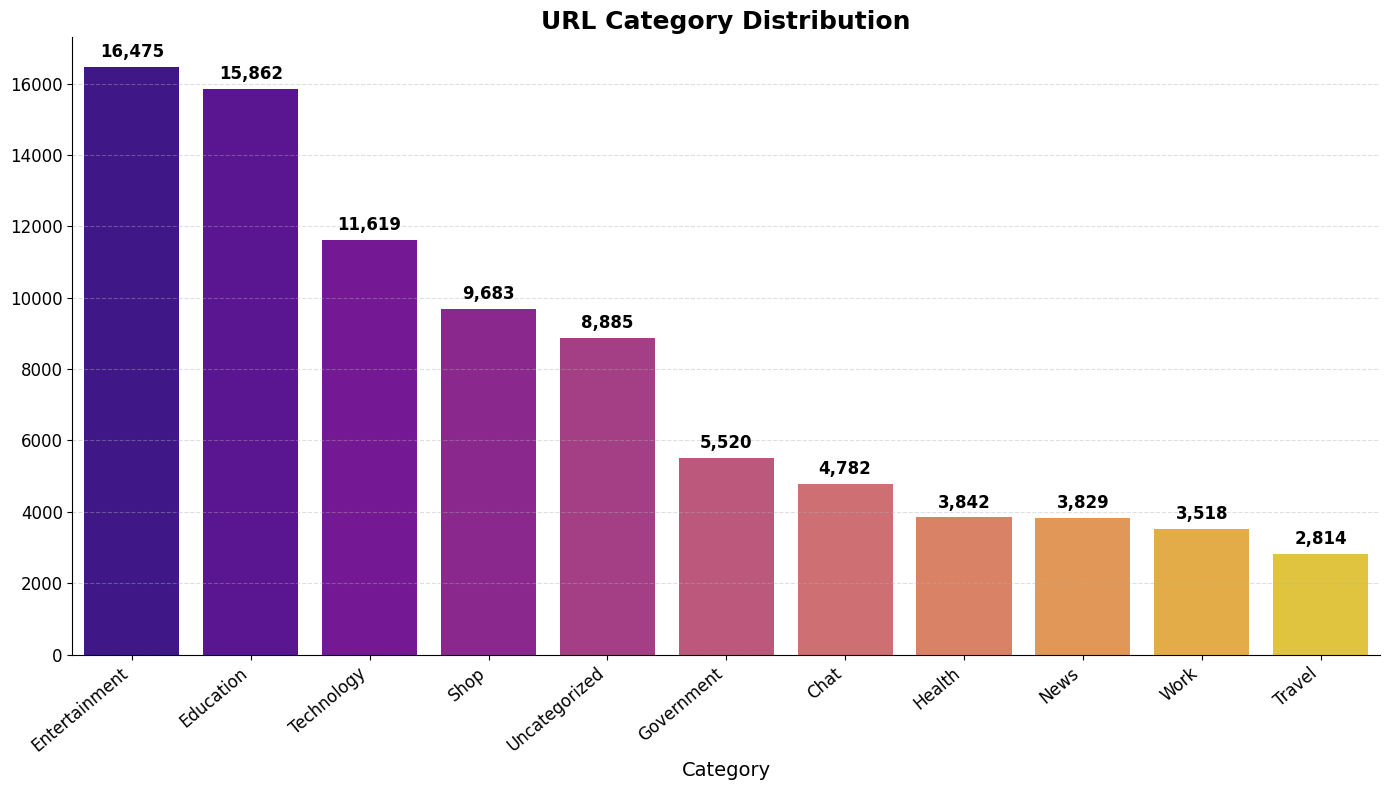

In [27]:
# Plot 1: Category Distribution Bar Chart
sorted_counts = filtered_counts.sort_values(ascending=False)
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x=sorted_counts.index,
    y=sorted_counts.values,
    palette='plasma', 
    hue=sorted_counts.index
)
plt.title('URL Category Distribution', fontsize=18, weight='bold')
plt.xlabel('Category', fontsize=14)
plt.xticks(rotation=40, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
# Add labels on top of bars
for i, count in enumerate(sorted_counts.values):
    ax.text(i, count + max(sorted_counts.values) * 0.01, f"{count:,}",  # Added comma formatting
            ha='center', va='bottom', fontsize=12, fontweight='semibold')
sns.despine()
plt.tight_layout()
plt.show()

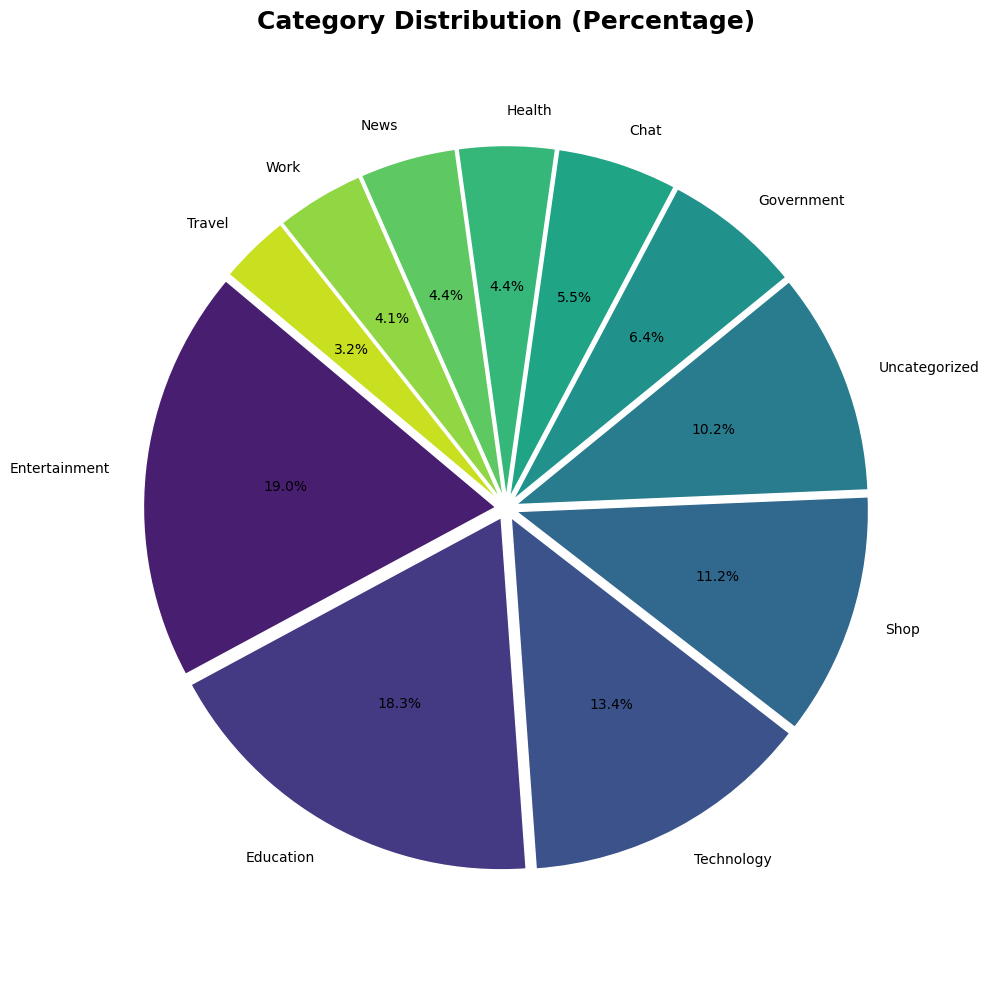

In [28]:
# Plot 2: Category Distribution Pie Chart
sorted_counts = filtered_counts.sort_values(ascending=False)
colors = sns.color_palette('viridis', len(sorted_counts))
explode = [0.03] * len(sorted_counts)
plt.figure(figsize=(10, 10))
plt.pie(
    sorted_counts,
    labels=sorted_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.title('Category Distribution (Percentage)', fontsize=18, weight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

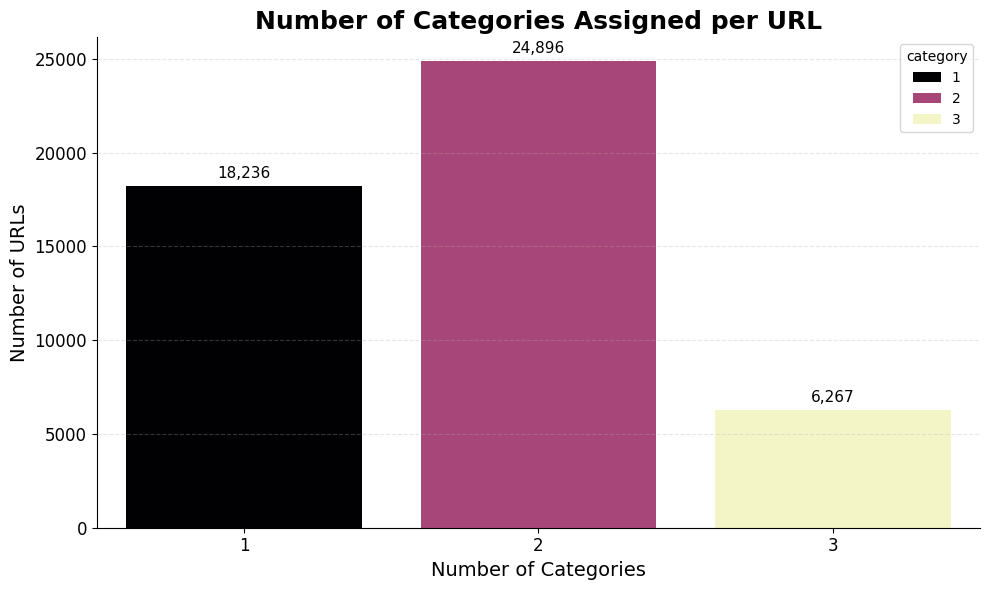

In [29]:
# Plot 3: Multi-label Analysis - Number of categories per URL
label_counts = df['category'].apply(len).value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    palette='magma',
    hue=label_counts.index
)
plt.title('Number of Categories Assigned per URL', fontsize=18, weight='bold')
plt.xlabel('Number of Categories', fontsize=14)
plt.ylabel('Number of URLs', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add count labels on top of bars
for i, count in enumerate(label_counts.values):
    ax.text(i, count + max(label_counts.values) * 0.01, f"{count:,}",  # Added comma formatting
            ha='center', va='bottom', fontsize=11, fontweight='medium')

sns.despine()
plt.tight_layout()
plt.show()

In [30]:
# Initialize co-occurrence matrix
cooccurrence = pd.DataFrame(0, index=allowed_categories, columns=allowed_categories)
# Populate co-occurrence matrix
for labels in df['category']:
    unique_labels = set(labels)
    for cat1 in unique_labels:
        for cat2 in unique_labels:
            if cat1 in allowed_categories and cat2 in allowed_categories:
                cooccurrence.loc[cat1, cat2] += 1
combination_counts = Counter(tuple(sorted(labels)) for labels in df['category'] if len(labels) > 0)

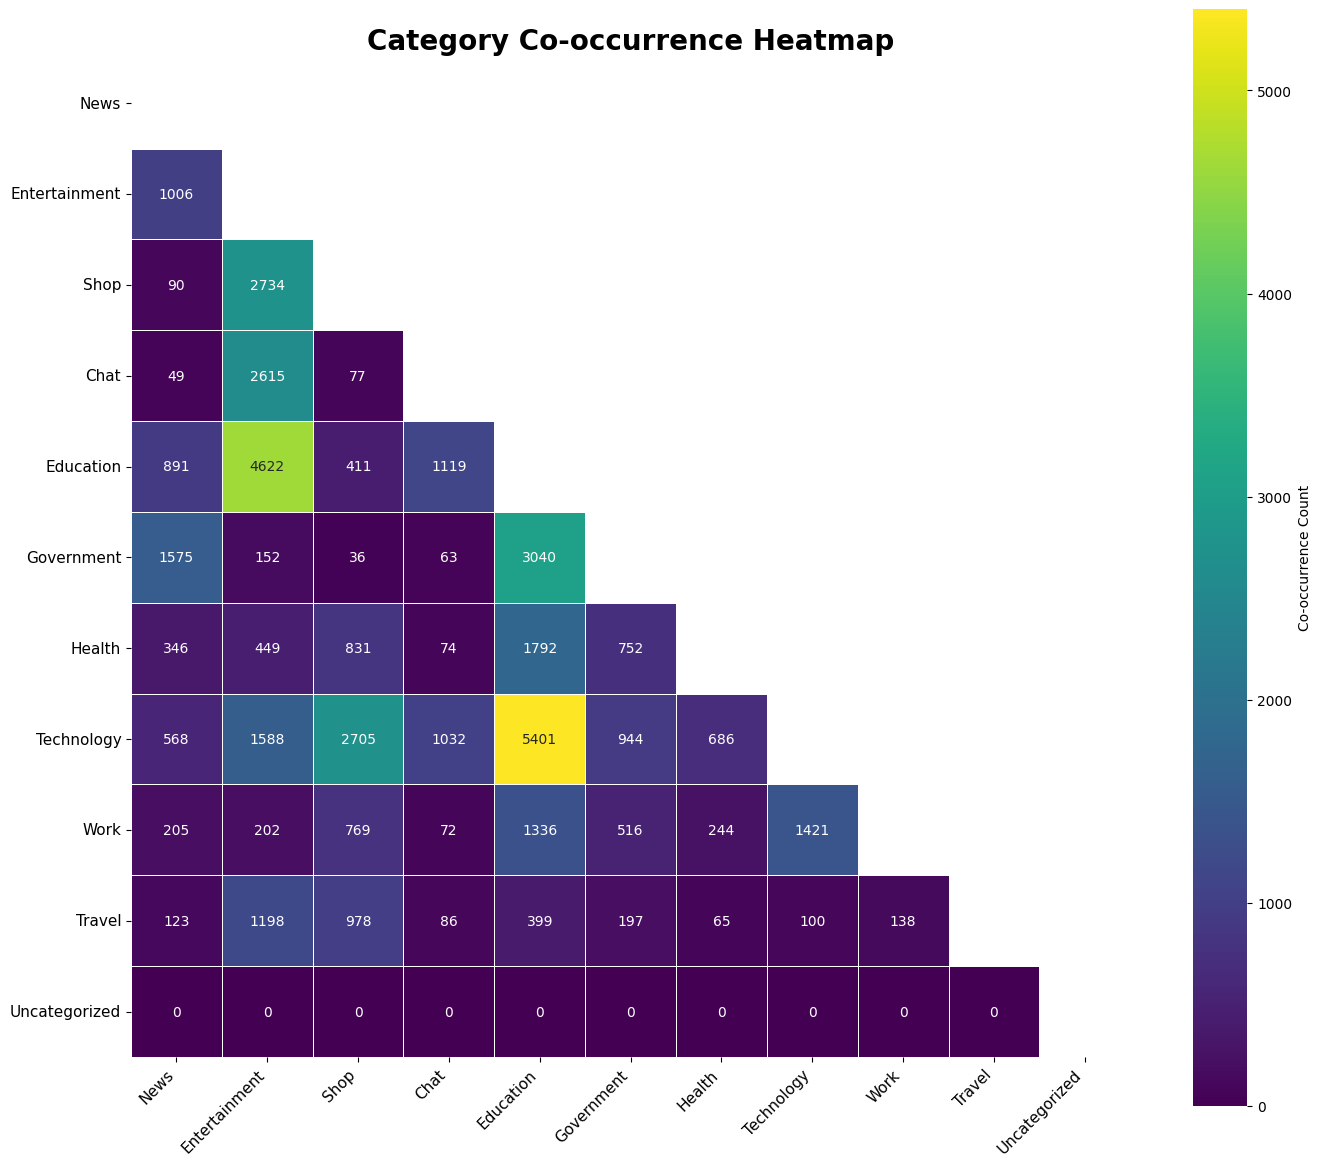

In [31]:
# Plot 4: Category Co-occurrence Heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(cooccurrence, dtype=bool))  # Use cooccurrence DataFrame

sns.heatmap(
    cooccurrence,  # Use cooccurrence DataFrame
    mask=mask,
    annot=True,
    fmt='d',
    cmap='viridis',
    linewidths=0.5,
    square=True,
    cbar_kws={'label': 'Co-occurrence Count'}
)

plt.title('Category Co-occurrence Heatmap', fontsize=20, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

In [32]:
# Calculate conditional probabilities
conditional_prob = pd.DataFrame(0.0, index=allowed_categories, columns=allowed_categories)
for cat1 in allowed_categories:
    for cat2 in allowed_categories:
        if cat1 != cat2 and filtered_counts.get(cat1, 0) > 0:
            conditional_prob.loc[cat1, cat2] = cooccurrence.loc[cat1, cat2] / filtered_counts[cat1]

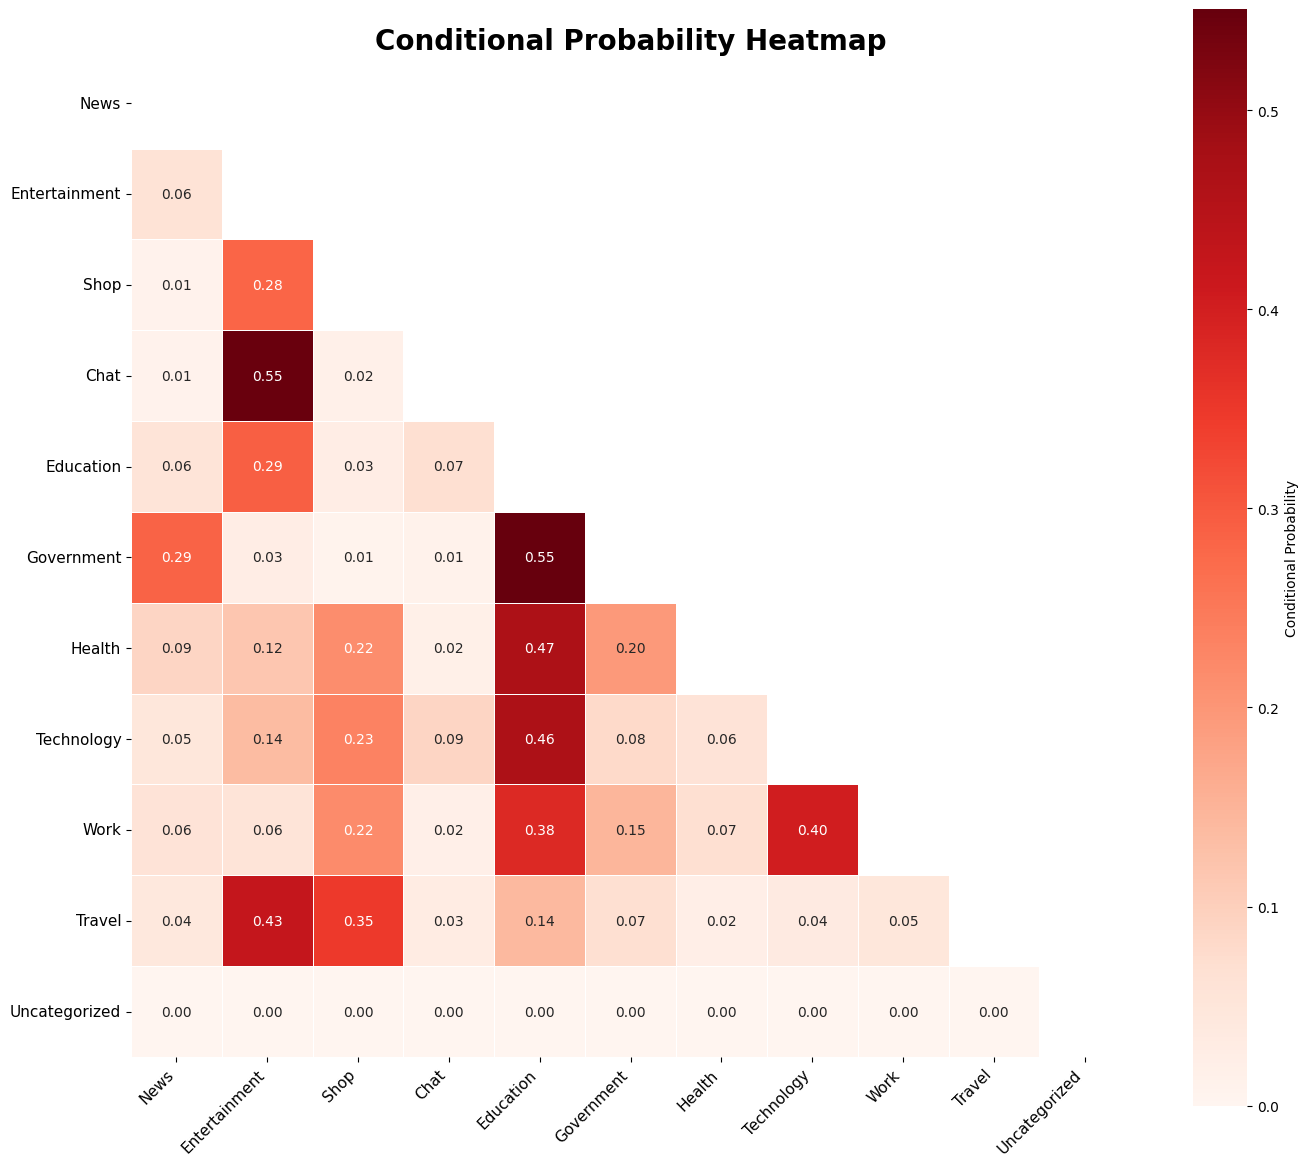

In [33]:
# Plot 5: Conditional Probability Heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(conditional_prob, dtype=bool))  # Use conditional_prob DataFrame

sns.heatmap(
    conditional_prob,  # Use conditional_prob DataFrame
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='Reds',
    linewidths=0.5,
    square=True,
    cbar_kws={'label': 'Conditional Probability'}
)

plt.title('Conditional Probability Heatmap', fontsize=20, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

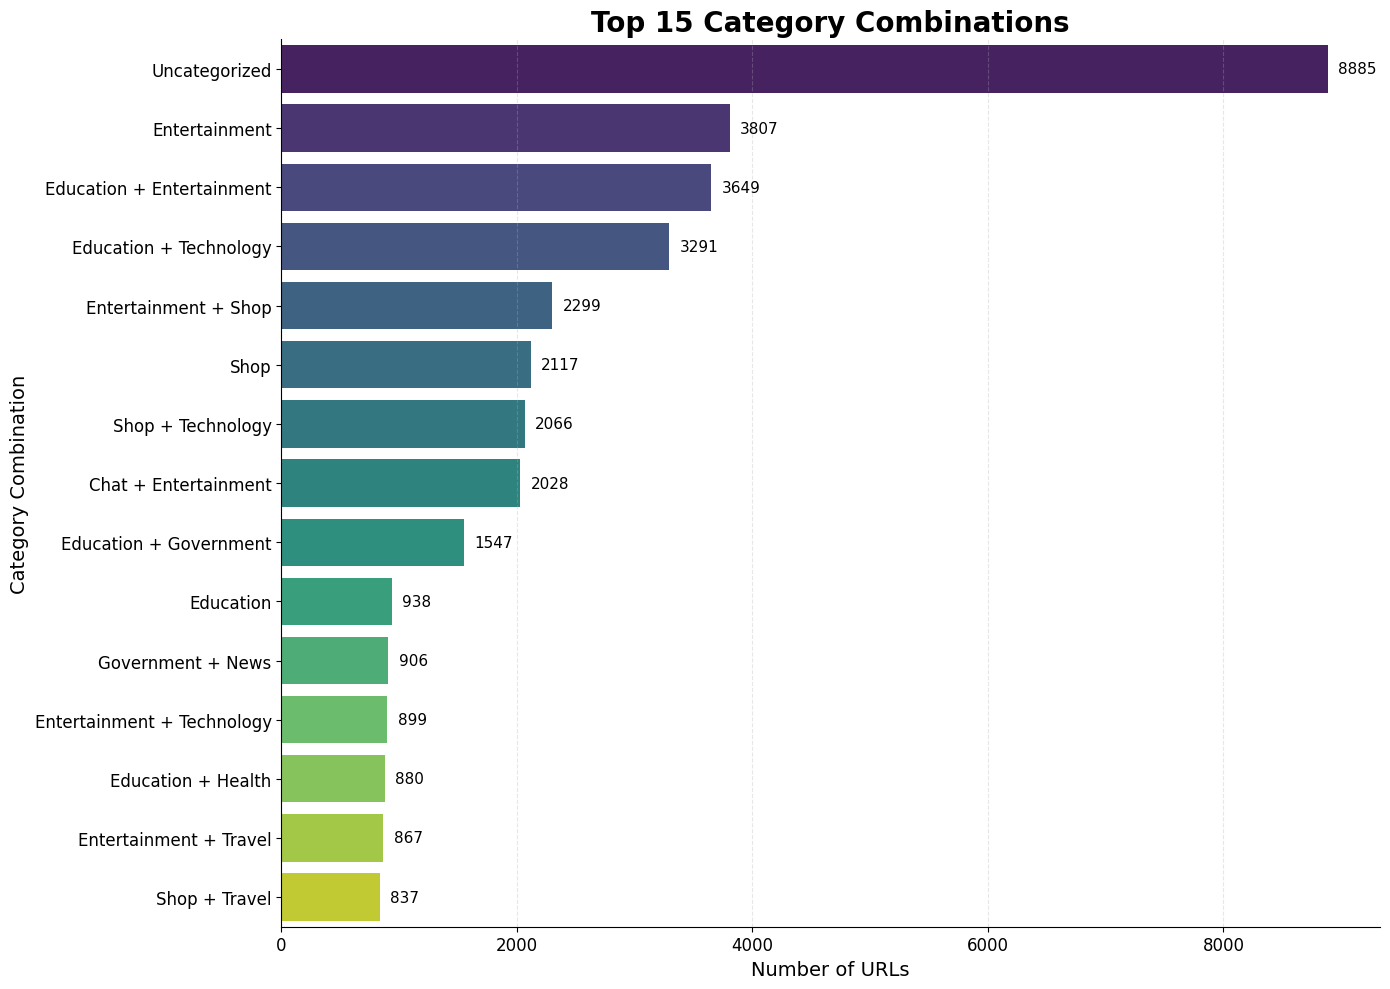

In [34]:

# Plot 6: Top Category Combinations
top_n = 15
top_combinations = combination_counts.most_common(top_n)
labels = [' + '.join(combo) for combo, _ in top_combinations]
counts = [count for _, count in top_combinations]

plt.figure(figsize=(14, 10))
ax = sns.barplot(x=counts, y=labels, palette='viridis', hue=labels)

plt.title(f'Top {top_n} Category Combinations', fontsize=20, weight='bold')
plt.xlabel('Number of URLs', fontsize=14)
plt.ylabel('Category Combination', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Add count labels at end of bars
for i, count in enumerate(counts):
    ax.text(count + max(counts) * 0.01, i, f'{count}', va='center', fontsize=11)

sns.despine()
plt.tight_layout()
plt.show()

/var/folders/mr/tyfws3nn2l95dknzdwqjbyyh0000gn/T/ipykernel_64118/2681732972.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='title_length', data=df_exploded, palette='Set2')


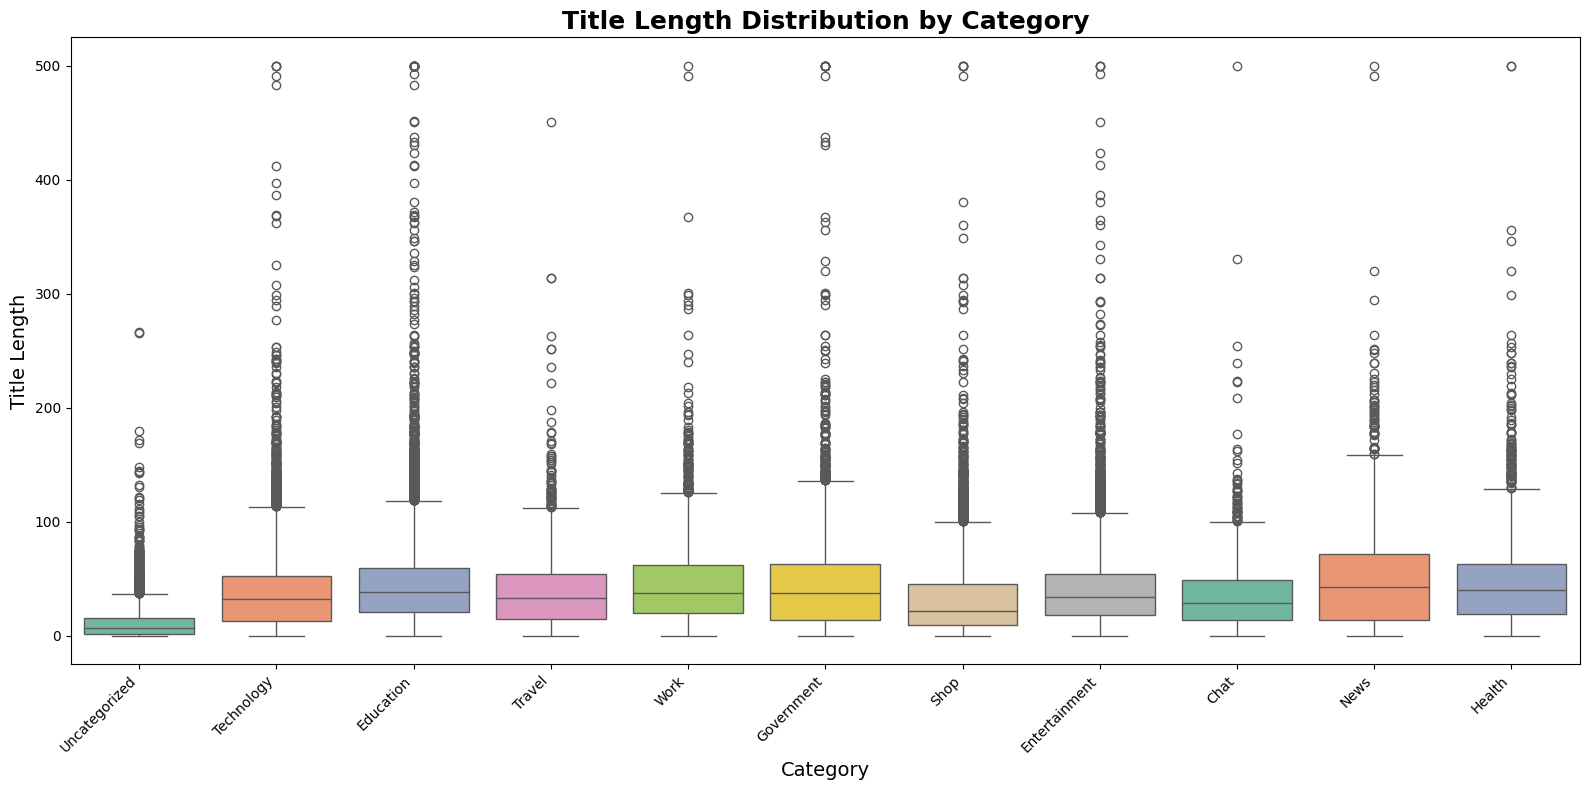

In [35]:
# Plot 7: title lenght vs category
plt.figure(figsize=(16, 8))
sns.boxplot(x='category', y='title_length', data=df_exploded, palette='Set2')
plt.title('Title Length Distribution by Category', fontsize=18, fontweight='bold')
plt.xlabel('Category', fontsize=14)
plt.ylabel('Title Length', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/mr/tyfws3nn2l95dknzdwqjbyyh0000gn/T/ipykernel_64118/2613566953.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='url_length', data=df_exploded, palette='Set2')


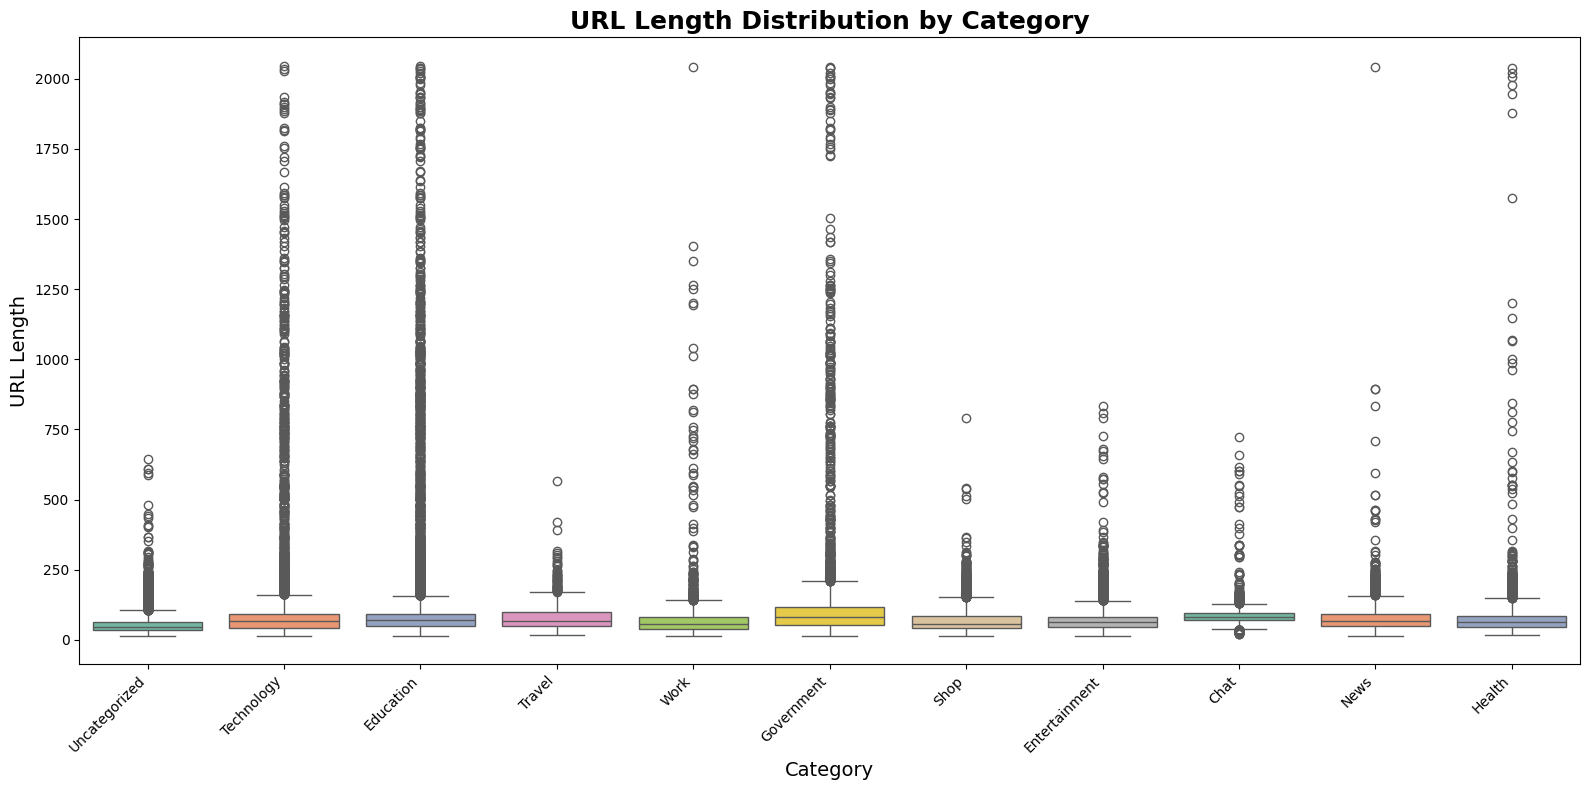

In [36]:
#plot 8: url length vs category
plt.figure(figsize=(16, 8))
sns.boxplot(x='category', y='url_length', data=df_exploded, palette='Set2')
plt.title('URL Length Distribution by Category', fontsize=18, fontweight='bold')
plt.xlabel('Category', fontsize=14)
plt.ylabel('URL Length', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/mr/tyfws3nn2l95dknzdwqjbyyh0000gn/T/ipykernel_64118/859067445.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='url_special_count', data=df_exploded, palette='Set2')


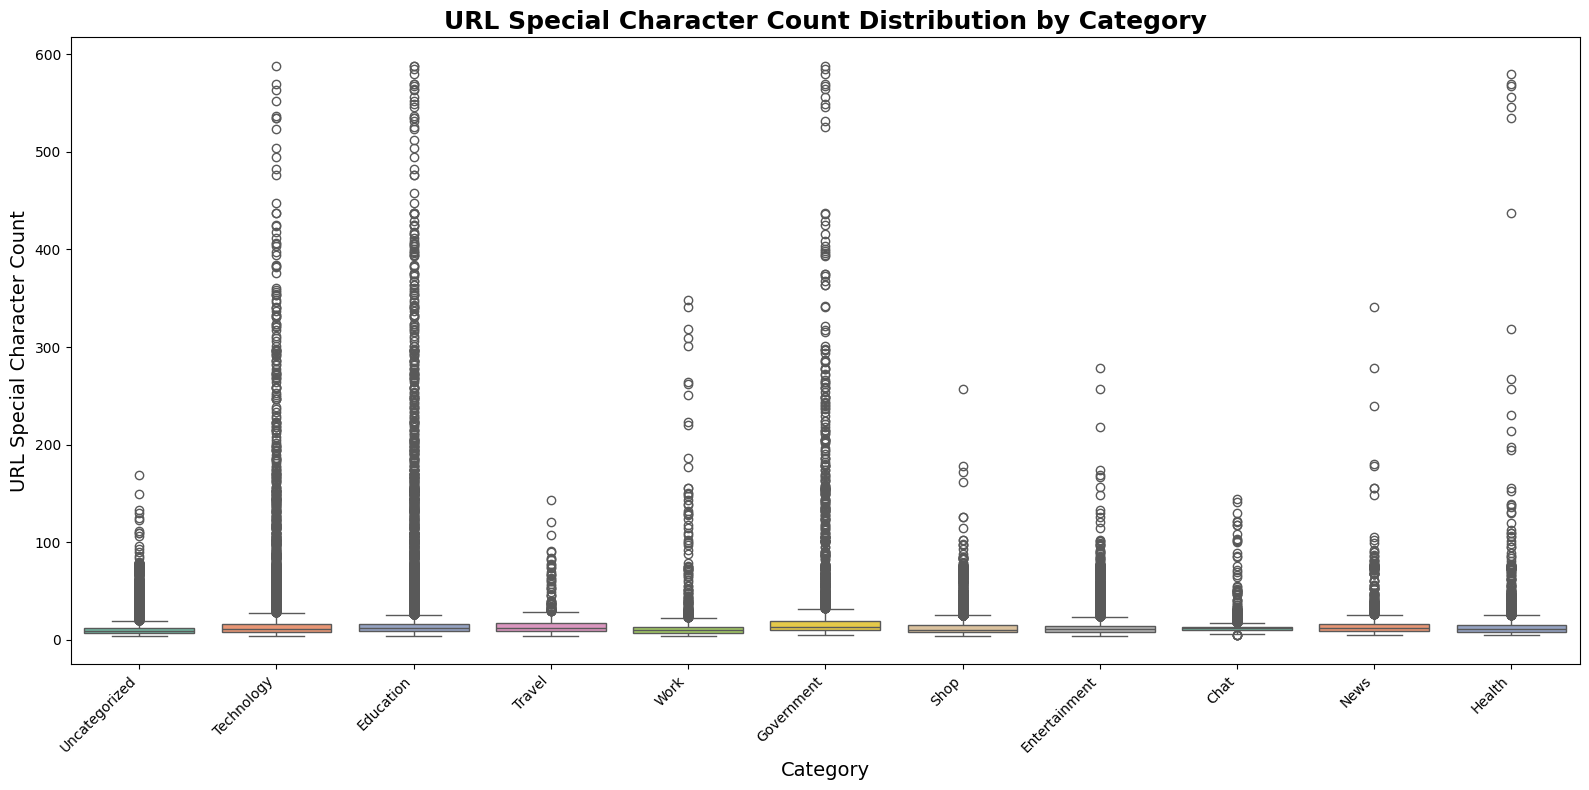

In [37]:
#plot 9: url special character count vs category
plt.figure(figsize=(16, 8))
sns.boxplot(x='category', y='url_special_count', data=df_exploded, palette='Set2')
plt.title('URL Special Character Count Distribution by Category', fontsize=18, fontweight='bold')
plt.xlabel('Category', fontsize=14)
plt.ylabel('URL Special Character Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/mr/tyfws3nn2l95dknzdwqjbyyh0000gn/T/ipykernel_64118/3147421385.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='title_word_count', data=df_exploded, palette='Set2')


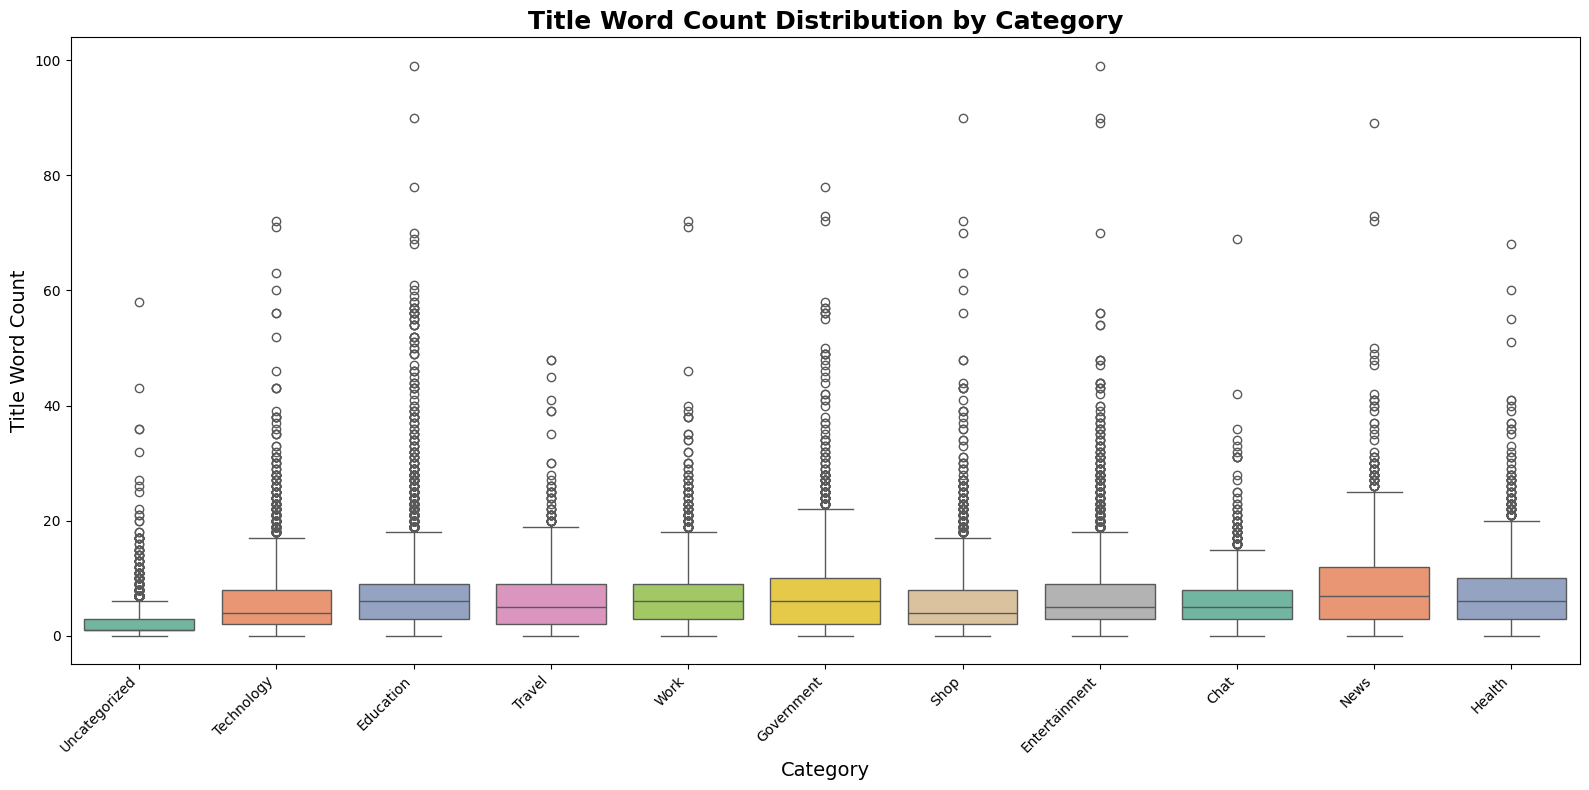

In [38]:
#plot 10: title word count vs category
plt.figure(figsize=(16, 8))
sns.boxplot(x='category', y='title_word_count', data=df_exploded, palette='Set2')
plt.title('Title Word Count Distribution by Category', fontsize=18, fontweight='bold')
plt.xlabel('Category', fontsize=14)
plt.ylabel('Title Word Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()